# 1. Facial Recognition Project in Python
## 1.1 Show images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from util import getData

In [22]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

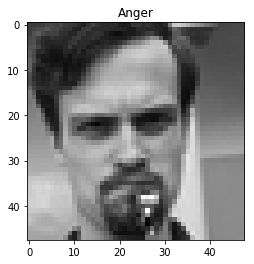

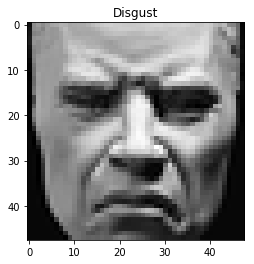

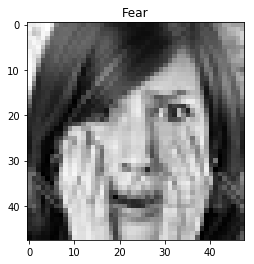

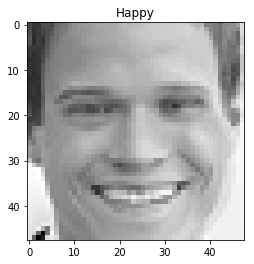

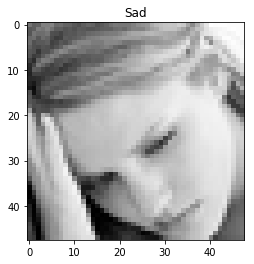

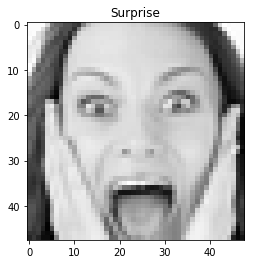

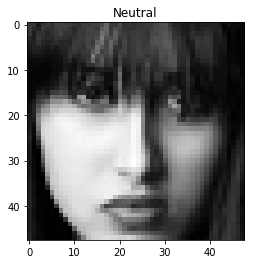

Quit? Enter Y:
Y


In [23]:
def main(): 
    X, Y = getData(balance_ones=False)    # X = (35887, 2304) , Y = (35887,1)
    
    while True:
        for i in range(7):                # loop through each of the 7 emotions
            x, y = X[Y==i], Y[Y==i]       # choose all data points that equal that emotion
            N = len(y)                    # get number of data points equal to this emotion
            j = np.random.choice(N)       # randomly select data point
            
            # plot data point, must reshape to 48x48 image because data lives in flat vectors
            plt.imshow(x[j].reshape(48, 48), cmap='gray')    
            plt.title(label_map[y[j]])
            plt.show()
        
        # because this is an infinite loop, we need a prompt to quit or not
        prompt = input('Quit? Enter Y:\n')
        if prompt == 'Y':
            break
            
if __name__ == '__main__':
    main()

## Notes on Structure of Data
Each image sample is a 48x48 pixel image. This means that we have 2304 input dimensions. If the images had contained color, it would have been 3x48x48 = 6912 dimensions. When we work with logistic regression and basic neural netowkrs we will use a flat 2304 dimensional vector. This means that spatial relationships are ignored. We can think of it like this: originally, an input image would look like:
* [ - row 1 -] (1-48)
* [ - row 2 -] (49-96)
* And so on all the way to the 2304. But we are flattening it so that we have a 2304x 1 vector, as so:
* [ - row 1 - row 2 - row 3 - ...] (1-2304)

If we had been using a convolutional neural network, we would keep the original image shape. 
## Normalize the data
Another preproccesing step that we will want to do is normalize the data. Image pixel intensities range from 0 .. 255 (8 bit integers have 2^8 = 256 different possible values). We want to normalize these to be from 0 to 1, since the sigmoid and tanh are most active in the -1 to +1 range. Normalization can look like: 
#### $$z = \frac{(x - mean)}{stddev}$$
But because these are pixel values and are strictly positive, we can just divide by the maximum value. 

## Class Imbalance Problem
For our logistic regression implementation, not that we are going to perform binary classifcation (not utilizing softmax). We will just look at class 1 and class 0 for this. However, class 1 only has 547 examples, and class 0 has 4853 examples. This is known as a class imbalance. How do we deal with this problem? 

Well, suppose we have 1000 samples from class 1, and 100 samples from class 2. One simple method is to pick 100 samples from class 1, now we have 100 vs 100. Another method is to Repeat class 2 10 times, now we have 1000 vs 1000. Both of these methods have the same expected error rate, however, the second method is better, because it has less variance and incorporates more data. 

We could also add some Gaussian noise when creating more samples for class 2. 


---
<br></br>
# FER Code - Binary/Sigmoid
Before we move on to softmax, we are going to use a neural network with a sigmoid, so we can compare binary classification with logistic regression which we have done before, to a neural network. As always, start with our imports. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from util import getBinaryData, sigmoid, sigmoid_cost, error_rate, relu

Now, let's define a class `ANN`. It will have an initializer that is called with the `__init__` method. 

In [22]:
class ANN(object):
    def __init__(self, M):         # pass in the number of hidden units of model, M
        self.M = M                 # set M property of class to M hidden units 
        
    """
    Fit function
    Params: X, Y, learning_rate, regularization term, number iterations, show_fig
    Input matrix X is size (N x D)
    Hidden layer Z is size (N x M)
    Output Layer is size (N x 1)
    W1 is size (D x M)
    W2 is size (M x 1)
    """
    def fit(self, X, Y, learning_rate=5*10e-7, reg=1.0, epochs=10000, show_fig=False):   
        X, Y = shuffle(X, Y)                       # start by shuffling X and Y
        Xvalid, Yvalid = X[-1000:], Y[-1000:]      # split data into training and validation
        X, Y = X[:-1000], Y[:-1000]       
        
        # initialize weights
        N, D = X.shape               
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)       
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M) / np.sqrt(self.M)
        self.b2 = 0
        
        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation
            pY, Z = self.forward(X)
            
            # gradient descent step 
            pY_Y = pY - Y                     # prediction - targets, size (N x 1)
            self.W2 -= learning_rate * (Z.T.dot(pY_Y) + reg * self.W2)  
            self.b2 -= learning_rate * ((pY_Y).sum() + reg * self.b2)
        
            dZ = np.outer(pY_Y, self.W2) * (1 - Z*Z)
            self.W1 -= learning_rate * (X.T.dot(dZ) + reg * self.W1) 
            self.b1 -= learning_rate * (np.sum(dZ, axis=0) + reg*self.b1) 
            # above the sum is the same as a dot product with ones 
            
            if i % 100 == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = sigmoid_cost(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.round(pYvalid))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print ("best validation error:", best_validation_error)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    """Forward function"""
    def forward(self, X):
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return sigmoid(Z.dot(self.W2) + self.b2), Z
    
    """Predict Function"""
    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)
    
    """Score function"""
    def score(self, X ,Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

Now define our main method. 

In [24]:
def main():
    X, Y = getBinaryData()
    
    X0 = X[Y==0, :]
    X1 = X[Y==1, :]
    
    # fixing class imbalance problem
    X1 = np.repeat(X1, 9, axis=0)
    X = np.vstack([X0, X1])
    Y = np.array([0]*len(X0) + [1]*len(X1))
    
    # instantiate our ann model, then fit the model
    model = ANN(100)
    model.fit(X, Y, show_fig=True)

if __name__ == '__main__':
    main()

---
<br></br>
# FER Code - Logistic Regression with Softmax

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from util import getData, softmax, cost, y2indicator, error_rate
from sklearn.utils import shuffle

In [26]:
class LogisticModel(object):
    def __init__(self):
        pass
    
    def fit(self, X, Y, learning_rate=10e-8, reg=10e-12, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Tvalid = y2indicator(Yvalid)
        X, Y = X[:-1000], Y[:-1000]
        
        N, D = X.shape
        K = len(set(Y))         # get number of classes
        T = y2indicator(Y)
        self.W = np.random.randn(D, K) / np.sqrt(D)   # initialize weight and bias
        self.b = np.zeros(K)                          # only 1 weight and bias bc logistic reg
        
        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY = self.forward(X)
        
            # gradient descent step
            self.W -= learning_rate*(X.T.dot(pY - T) + reg*self.W)
            self.b -= learning_rate*((pY - T).sum(axis=0) + reg*self.b)
         
            if i % 10 == 0:
                pYvalid = self.forward(Xvalid)
                c = cost(Tvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
        
    def forward(self, X):
        return softmax(X.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return np.argmax(pY, axis=1)

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

In [28]:
def main():
    X, Y = getData()
    
    model = LogisticModel()
    model.fit(X, Y, show_fig=True)
    print(model.score(X, Y))

if __name__ == '__main__':
    main()

---
<br></br>
# FER Code - ANN with Softmax

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from util import getData, softmax, cost2, y2indicator, error_rate, relu
from sklearn.utils import shuffle

class ANN(object):
    def __init__(self, M):
        self.M = M

    # learning rate 10e-6 is too large
    def fit(self, X, Y, learning_rate=10e-7, reg=10e-7, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        # Tvalid = y2indicator(Yvalid)
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        K = len(set(Y))
        T = y2indicator(Y)
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M, K) / np.sqrt(self.M)
        self.b2 = np.zeros(K)

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY, Z = self.forward(X)

            # gradient descent step
            pY_T = pY - T
            self.W2 -= learning_rate*(Z.T.dot(pY_T) + reg*self.W2)
            self.b2 -= learning_rate*(pY_T.sum(axis=0) + reg*self.b2)
            # dZ = pY_T.dot(self.W2.T) * (Z > 0) # relu
            dZ = pY_T.dot(self.W2.T) * (1 - Z*Z) # tanh
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1)
            self.b1 -= learning_rate*(dZ.sum(axis=0) + reg*self.b1)

            if i % 10 == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = cost2(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        # Z = relu(X.dot(self.W1) + self.b1)
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return softmax(Z.dot(self.W2) + self.b2), Z

    def predict(self, X):
        pY, _ = self.forward(X)
        return np.argmax(pY, axis=1)

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

In [ ]:
def main():
    X, Y = getData()
    
    model = ANN(200)
    model.fit(X, Y, reg=0, show_fig=True)
    print(model.score(X, Y))
    # scores = cross_val_score(model, X, Y, cv=5)
    # print "score mean:", np.mean(scores), "stdev:", np.std(scores)

if __name__ == '__main__':
    main()
